## 🔗 Open This Notebook in Google Colab

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DavidLangworthy/ds4s/blob/master/days/day01/starter/day01_starter.ipynb)

# 🌎 Day 1 – Visualizing Global Warming
### Introduction to Jupyter, Python, and Climate Data

Welcome to Day 1! Today you'll take your first steps in data storytelling with Python. We'll use NASA's global temperature anomaly record to build a transparent, trustworthy line chart that tracks how the planet has warmed since 1880.

👉 **Course rhythm for today:** learn a concept, try it right away, run a quick check, repeat. By the end you'll have a finished figure plus a reusable workflow for future days.

### Data card — NASA GISTEMP Global Land-Ocean Temperature Index
- **Source:** [NASA GISS Surface Temperature Analysis (GISTEMP)](https://data.giss.nasa.gov/gistemp)
- **Temporal coverage:** 1880–present (monthly anomalies relative to 1951–1980)
- **Spatial coverage:** Global land and ocean blended series
- **Units:** Temperature anomaly (°C) relative to a 1951–1980 baseline
- **Update cadence:** Monthly, revised as new observations arrive
- **Processing notes:** NASA performs homogenization and combines land weather stations with sea-surface measurements. Missing values are flagged with `***`.
- **Caveats:** Short-term variations can be noisy; annual means smooth weather variability but do not represent absolute temperature. Always cite the baseline and acknowledge uncertainty (~±0.05 °C recent decades).

### Preview: what you're building today
The final visualization highlights the accelerating warming trend and calls out the most recent anomaly. Use it as your north star while you move through each step.

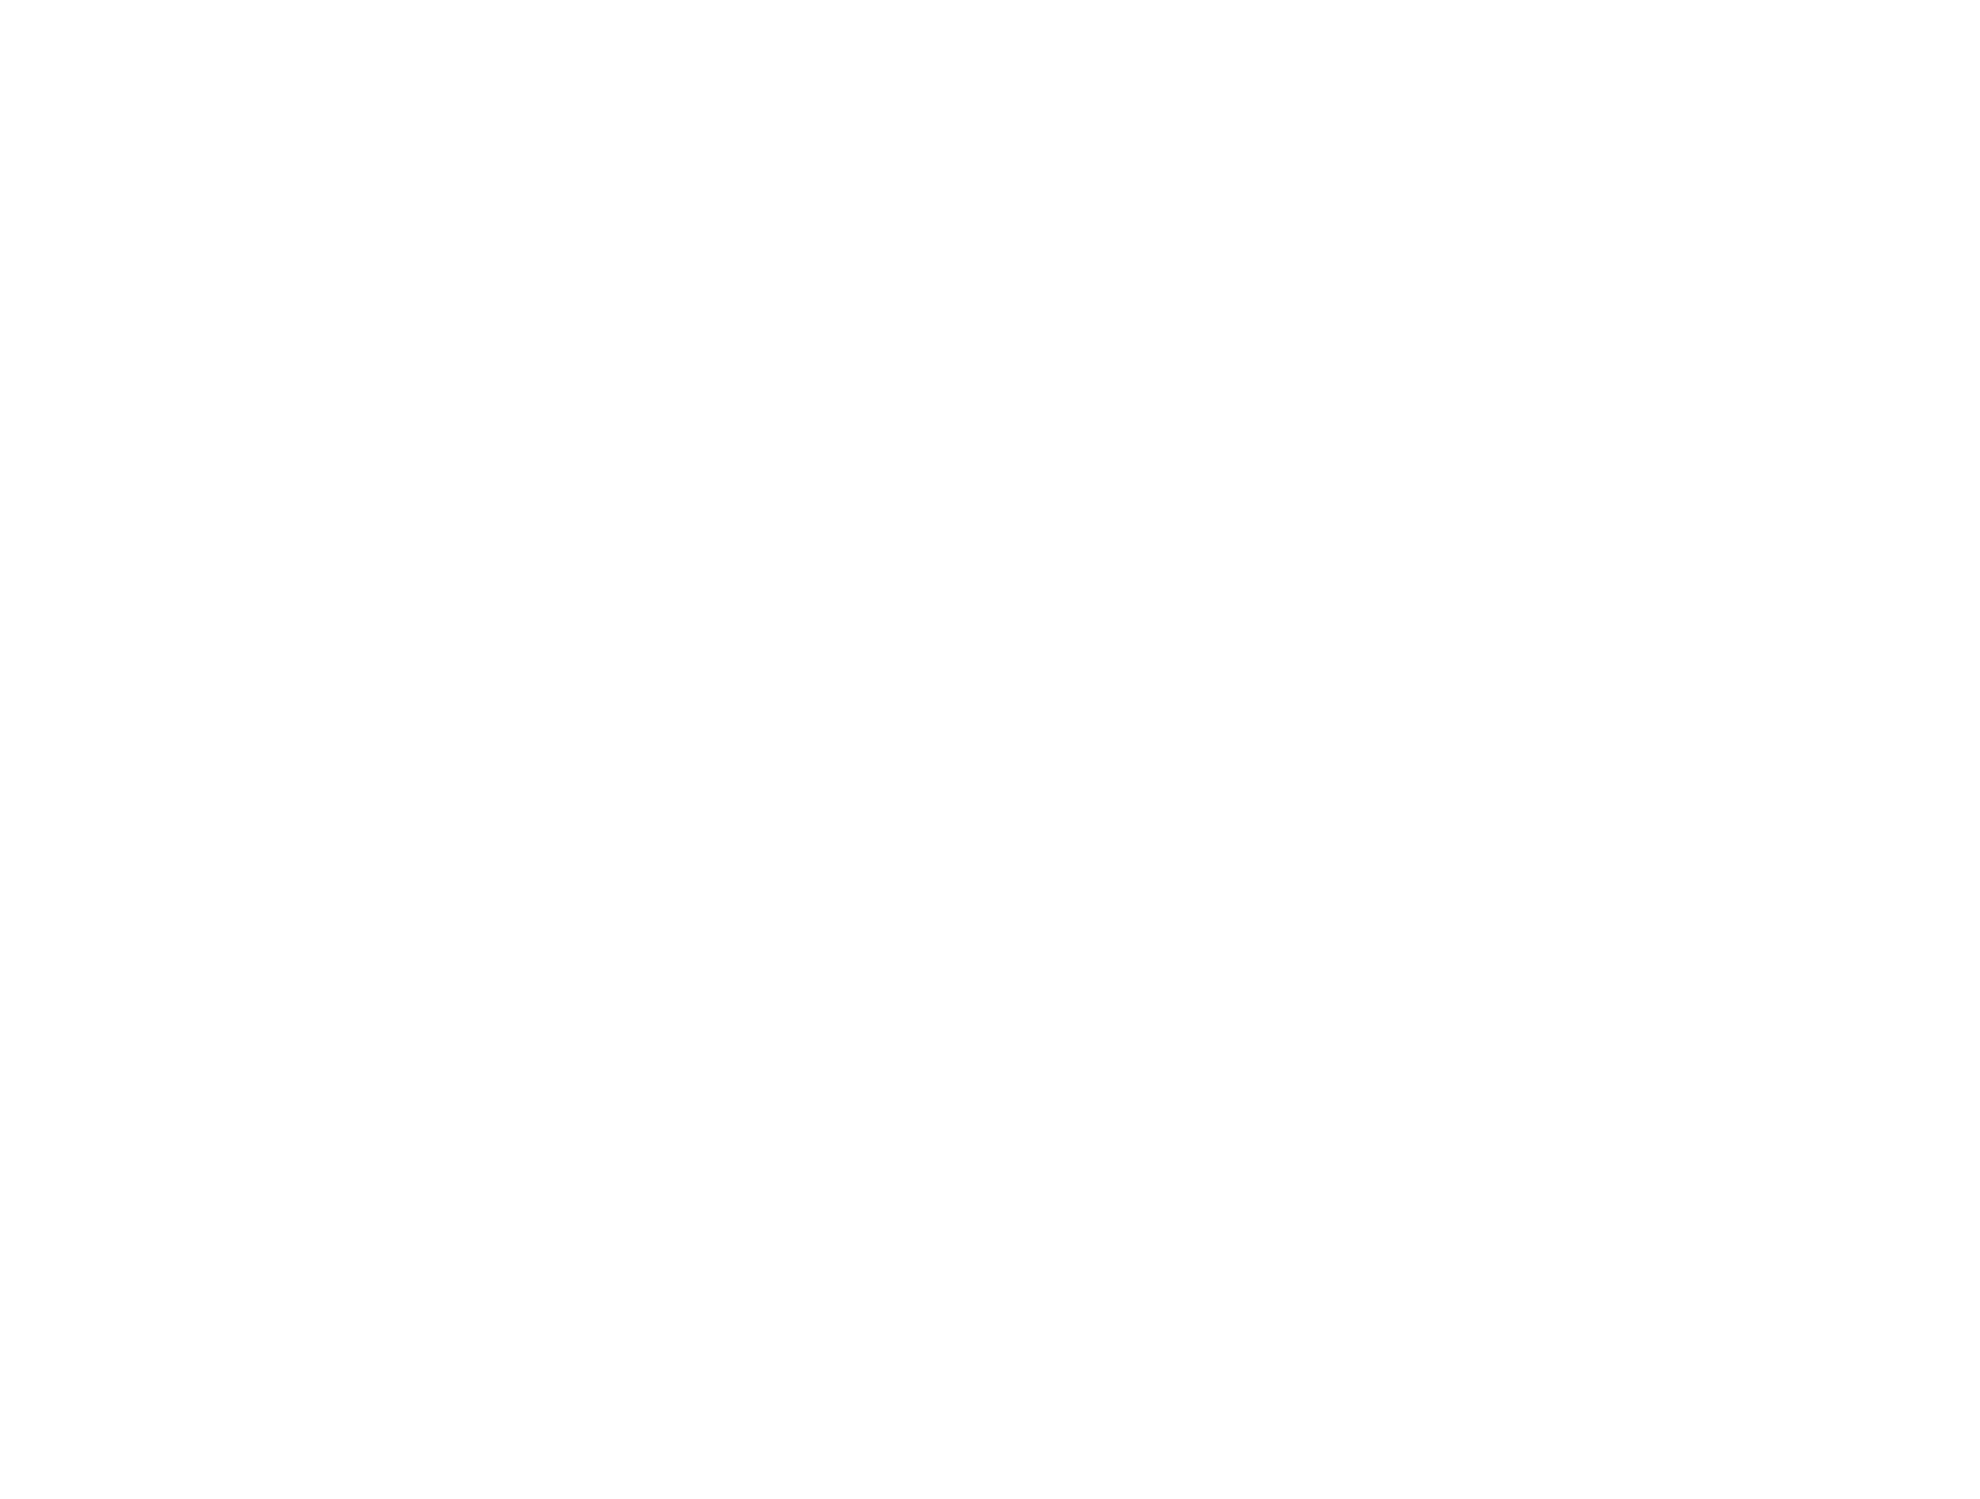

In [1]:
from pathlib import Path
from warnings import warn

import pandas as pd
import requests
import matplotlib.pyplot as plt
from IPython.display import Image, display

CANDIDATES = [Path.cwd(), *Path.cwd().parents]
for candidate in CANDIDATES:
    if (candidate / "data").exists():
        PROJECT_ROOT = candidate
        break
else:
    raise FileNotFoundError("Couldn't find the project root containing a data/ folder.")

DATA_DIR = PROJECT_ROOT / "data"
RAW_DATA_BASE = "https://raw.githubusercontent.com/DavidLangworthy/ds4s/master/data"
PLOTS_DIR = PROJECT_ROOT / "plots"
PLOTS_DIR.mkdir(exist_ok=True)

plt.rcParams.update({
    "figure.dpi": 110,
    "axes.titlesize": 16,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.grid": True,
    "grid.alpha": 0.3,
})

COLORBLIND_FRIENDLY = ["#2E86AB", "#F18F01", "#A23B72", "#C73E1D", "#2EC4B6"]

if (PLOTS_DIR / "day01_solution_plot.png").exists():
    display(Image(filename=PLOTS_DIR / "day01_solution_plot.png", width=420))
else:
    print("Preview image not found; continue with the workflow.")


def load_data(csv_name: str, **read_kwargs) -> pd.DataFrame:
    path = DATA_DIR / csv_name
    if not path.exists():
        url = f"{RAW_DATA_BASE}/{csv_name}"
        print(f"Local file not found. Downloading {csv_name} from GitHub…")
        response = requests.get(url, timeout=30)
        try:
            response.raise_for_status()
        except requests.HTTPError as exc:
            raise FileNotFoundError(
                f"Could not retrieve {csv_name} from {url} (status {response.status_code})."
            ) from exc
        path.parent.mkdir(parents=True, exist_ok=True)
        path.write_bytes(response.content)
    df = pd.read_csv(path, **read_kwargs)
    print(f"Loaded {csv_name} → {df.shape[0]:,} rows × {df.shape[1]} columns.")
    return df

def validate_columns(df: pd.DataFrame, required: list[str]) -> None:
    missing = [col for col in required if col not in df.columns]
    if missing:
        warn(f"Missing columns: {missing}")
    else:
        print("✅ Columns look good:", required)


def expect_rows_between(df: pd.DataFrame, lower: int, upper: int) -> None:
    rows = len(df)
    if rows < lower or rows > upper:
        warn(f"Row count {rows:,} outside the expected range ({lower:,}–{upper:,}).")
    else:
        print(f"✅ Row count within expected range ({rows:,}).")


def quick_diagnostics(df: pd.DataFrame, name: str = "DataFrame") -> None:
    print(f"--- Quick check for {name} ---")
    print("Shape:", df.shape)
    print("Columns:", list(df.columns))
    print("Missing values:", df.isna().sum())
    display(df.head())


def check_story_fields(**fields) -> None:
    empty = [key for key, value in fields.items() if not str(value).strip()]
    if empty:
        warn(f"These storytelling fields still need text: {', '.join(empty)}")
    else:
        print("✅ Story scaffolding complete. Ready to plot!")


def baseline_style():
    plt.style.use("seaborn-v0_8-whitegrid")
    plt.rcParams["axes.facecolor"] = "#F8FAFC"


def save_last_fig(filename: str) -> None:
    path = PLOTS_DIR / filename
    plt.savefig(path, dpi=300, bbox_inches="tight")
    print(f"Figure saved to {path.relative_to(PROJECT_ROOT)}")


## Step 1. Load and preview the NASA temperature anomalies
We skip the first metadata row, treat `***` as missing, and keep monthly anomaly columns. Run the quick diagnostics right after loading.

In [2]:
raw_temps = load_data(
    "GLB.Ts+dSST.csv",
    skiprows=1,
    na_values="***"
)
quick_diagnostics(raw_temps, name="raw NASA anomalies")


Loaded GLB.Ts+dSST.csv → 146 rows × 19 columns.
--- Quick check for raw NASA anomalies ---
Shape: (146, 19)
Columns: ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'J-D', 'D-N', 'DJF', 'MAM', 'JJA', 'SON']
Missing values: Year    0
Jan     0
Feb     0
Mar     0
Apr     1
May     1
Jun     1
Jul     1
Aug     1
Sep     1
Oct     1
Nov     1
Dec     1
J-D     1
D-N     2
DJF     1
MAM     1
JJA     1
SON     1
dtype: int64


,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
0,1880,-0.19,-0.25,-0.09,-0.17,-0.10,-0.21,-0.19,-0.11,-0.15,-0.24,-0.22,-0.18,-0.17,NaN,NaN,-0.12,-0.17,-0.20
1,1881,-0.20,-0.14,0.03,0.05,0.06,-0.19,0.00,-0.04,-0.16,-0.22,-0.19,-0.07,-0.09,-0.10,-0.17,0.04,-0.08,-0.19
2,1882,0.16,0.13,0.04,-0.16,-0.14,-0.23,-0.17,-0.08,-0.15,-0.24,-0.17,-0.37,-0.11,-0.09,0.07,-0.09,-0.16,-0.19
3,1883,-0.29,-0.37,-0.12,-0.19,-0.18,-0.07,-0.08,-0.14,-0.22,-0.12,-0.24,-0.11,-0.18,-0.20,-0.34,-0.16,-0.10,-0.20
4,1884,-0.13,-0.08,-0.36,-0.40,-0.34,-0.35,-0.31,-0.28,-0.27,-0.25,-0.34,-0.31,-0.29,-0.27,-0.11,-0.37,-0.31,-0.29


✅ **Checkpoint:** You should see 1880–2024 (or latest year) with columns for each month plus derived annual statistics. Expect roughly 170+ rows.

## Step 2. Focus on the annual mean anomaly
Students often forget to rename columns or convert units. We tidy the table to two columns: year and annual anomaly (°C).

In [3]:
annual_anomaly = (
    raw_temps[["Year", "J-D"]]
    .dropna()
    .rename(columns={"J-D": "anomaly_c"})
)
annual_anomaly["Year"] = annual_anomaly["Year"].astype(int)
annual_anomaly["anomaly_c"] = pd.to_numeric(annual_anomaly["anomaly_c"], errors="coerce")

validate_columns(annual_anomaly, ["Year", "anomaly_c"])
expect_rows_between(annual_anomaly, 140, 200)
quick_diagnostics(annual_anomaly, name="annual anomaly series")


✅ Columns look good: ['Year', 'anomaly_c']
✅ Row count within expected range (145).
--- Quick check for annual anomaly series ---
Shape: (145, 2)
Columns: ['Year', 'anomaly_c']
Missing values: Year         0
anomaly_c    0
dtype: int64


,Year,anomaly_c
0,1880,-0.17
1,1881,-0.09
2,1882,-0.11
3,1883,-0.18
4,1884,-0.29


### Mini self-diagnostic
If the anomaly column is `object` type or contains NaNs, revisit the conversion step above.

## Step 3. Smooth with a 5-year rolling mean for context
Short-term swings can distract from the long-term pattern. We'll add a rolling mean and compute anomaly change since 1880.

In [4]:
annual_anomaly = annual_anomaly.sort_values("Year").reset_index(drop=True)
annual_anomaly["anomaly_5yr"] = annual_anomaly["anomaly_c"].rolling(window=5, center=True).mean()

change_since_start = annual_anomaly["anomaly_c"].iloc[-1] - annual_anomaly["anomaly_c"].iloc[0]
print(f"Change from {annual_anomaly['Year'].iloc[0]} to {annual_anomaly['Year'].iloc[-1]}: {change_since_start:.2f} °C")

quick_diagnostics(annual_anomaly.tail(), name="recent anomalies")


Change from 1880 to 2024: 1.46 °C
--- Quick check for recent anomalies ---
Shape: (5, 3)
Columns: ['Year', 'anomaly_c', 'anomaly_5yr']
Missing values: Year           0
anomaly_c      0
anomaly_5yr    2
dtype: int64


,Year,anomaly_c,anomaly_5yr
140,2020,1.01,0.916
141,2021,0.85,0.980
142,2022,0.89,1.042
143,2023,1.17,NaN
144,2024,1.29,NaN


📝 **Micro-rubric reminder:** Reward yourself (or your learners) for documenting how smoothing changes the story, not just for finishing the plot.

## Step 4. Draft your story scaffold
Use the Claim → Evidence → Visual → Takeaway template. These strings feed directly into the chart and the caption block.

In [5]:
TITLE = "Global temperatures are nearly 1.3 °C warmer than the late 1800s"
SUBTITLE = "NASA GISTEMP global land–ocean temperature anomaly relative to 1951–1980 baseline"
ANNOTATION = "2024's anomaly is roughly {annual_anomaly['anomaly_c'].iloc[-1]:.2f} °C — more than double the warming seen in the mid-20th century."
SOURCE = "Source: NASA GISS Surface Temperature Analysis (GISTEMP v4)"
UNITS = "Units: Temperature anomaly (°C) relative to 1951–1980"

check_story_fields(
    TITLE=TITLE,
    SUBTITLE=SUBTITLE,
    ANNOTATION=ANNOTATION,
    SOURCE=SOURCE,
    UNITS=UNITS,
)


✅ Story scaffolding complete. Ready to plot!


## Step 5. Visualize with context and annotation
We combine the raw annual anomalies with the rolling mean, highlight the most recent year, and annotate the headline takeaway.

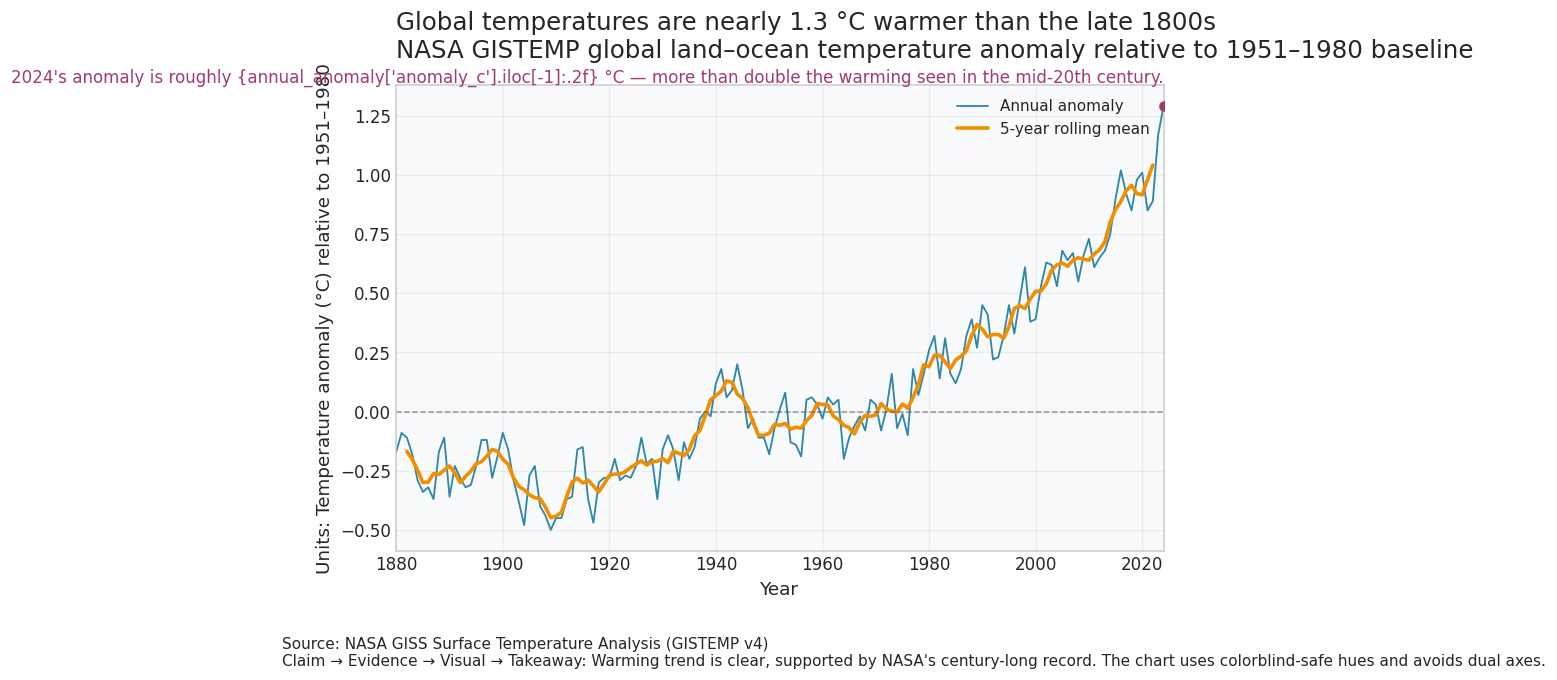

In [6]:
baseline_style()
fig, ax = plt.subplots(figsize=(9, 5.5))
ax.plot(
    annual_anomaly["Year"],
    annual_anomaly["anomaly_c"],
    color=COLORBLIND_FRIENDLY[0],
    linewidth=1.2,
    label="Annual anomaly"
)
ax.plot(
    annual_anomaly["Year"],
    annual_anomaly["anomaly_5yr"],
    color=COLORBLIND_FRIENDLY[1],
    linewidth=2.4,
    label="5-year rolling mean"
)

recent_year = annual_anomaly.iloc[-1]
ax.scatter(recent_year["Year"], recent_year["anomaly_c"], color=COLORBLIND_FRIENDLY[2], zorder=5)
ax.text(
    recent_year["Year"],
    recent_year["anomaly_c"] + 0.1,
    ANNOTATION,
    color=COLORBLIND_FRIENDLY[2],
    fontsize=11,
    ha="right"
)

title_text = TITLE + "\n" + SUBTITLE
ax.set_title(title_text, loc="left", pad=18)
ax.set_ylabel(UNITS)
ax.set_xlabel("Year")
ax.axhline(0, color="#555", linewidth=1, linestyle="--", alpha=0.6)
ax.legend(frameon=False)
ax.set_xlim(annual_anomaly["Year"].min(), annual_anomaly["Year"].max())

caption_text = SOURCE + "\n" + "Claim → Evidence → Visual → Takeaway: Warming trend is clear, supported by NASA's century-long record. The chart uses colorblind-safe hues and avoids dual axes."
fig.text(0.01, -0.08, caption_text, fontsize=10)
plt.show()


### Accessibility checklist
- Color palette passes colorblind-friendly checks.
- Fonts ≥ 10 pt for readability.
- Annotation text explains why the highlighted point matters.
- Units and source are explicit beneath the plot.

In [7]:
save_last_fig("day01_solution_plot.png")


Figure saved to plots/day01_solution_plot.png


<Figure size 704x528 with 0 Axes>

## Step 6. Reflect on limitations and uncertainty
- Baseline choice (1951–1980) affects the numeric anomaly but not the trend.
- Data combine land stations and sea-surface records with known sparse coverage in early years.
- Smoothing clarifies the long-term signal yet can hide abrupt events (e.g., volcanic eruptions).
- Always cite NASA GISTEMP version and update date when sharing publicly.